(517754, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<Axes: >

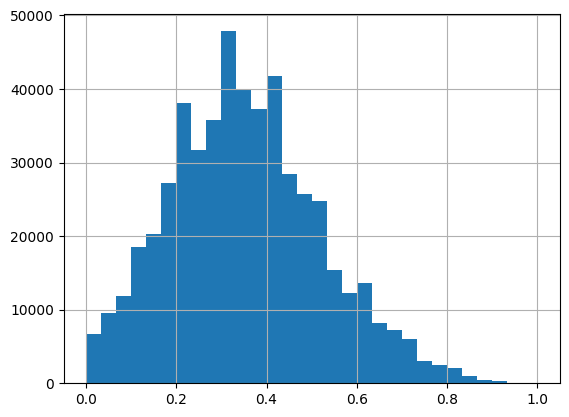

In [10]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Basic shape & info
print(train.shape)
train.info()

# Quick look
display(train.head())

# Target distribution
train['accident_risk'].describe()
train['accident_risk'].hist(bins=30)

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Data schema
cat_cols = [
    'road_type', 'lighting', 'weather', 'time_of_day', 'num_lanes',
    'road_signs_present', 'public_road', 'holiday', 'school_season'
]
num_cols = ['curvature', 'speed_limit', 'num_reported_accidents']
target_col = 'accident_risk'

def preprocess_tabular(train_df, test_df, cat_cols, num_cols, target_col):
    """
    Encodes categoricals, scales numerics, returns numpy arrays and metadata for embeddings.
    """
    df_train = train_df.copy()
    df_test = test_df.copy()

    # ---------- 1. Encode categoricals ----------
    cat_cardinalities = {}
    for c in cat_cols:
        # Combine train + test to ensure consistent category codes
        all_vals = pd.concat([df_train[c], df_test[c]], axis=0).astype('category')
        df_train[c] = all_vals[:len(df_train)].cat.codes.astype('int64')
        df_test[c]  = all_vals[len(df_train):].cat.codes.astype('int64')
        cat_cardinalities[c] = int(all_vals.cat.categories.size)

    # ---------- 2. Scale numeric features ----------
    scaler = StandardScaler()
    df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
    df_test[num_cols]  = scaler.transform(df_test[num_cols])

    # ---------- 3. Final feature ordering ----------
    feature_cols = cat_cols + num_cols
    X_train = df_train[feature_cols].values
    X_test  = df_test[feature_cols].values
    y_train = df_train[target_col].astype('float32').values

    # ---------- 4. Return everything ----------
    metadata = {
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "feature_cols": feature_cols,
        "cat_cardinalities": cat_cardinalities,
        "scaler": scaler
    }
    return X_train, y_train, X_test, metadata

X_train, y_train, X_test, meta = preprocess_tabular(
    train, test,
    cat_cols=cat_cols,
    num_cols=num_cols,
    target_col=target_col
)

print("X_train shape:", X_train.shape)

X_train shape: (517754, 12)


In [15]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---- Device (CPU / CUDA / Apple Silicon MPS) ----
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device:", device)


# ---- Dataset ----
class TabDataset(Dataset):
    def __init__(self, X, y=None, n_cat=0):
        self.X, self.y, self.n_cat = X, y, n_cat
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        row = self.X[i]
        cat = torch.tensor(row[:self.n_cat], dtype=torch.long) if self.n_cat else None
        num = torch.tensor(row[self.n_cat:], dtype=torch.float32) if self.n_cat < len(row) else None
        if self.y is None:
            return cat, num
        return cat, num, torch.tensor(self.y[i], dtype=torch.float32)

# ---- Model ----
def emb_dim(card: int) -> int:
    # rule of thumb for tabular embeddings
    return int(min(50, round(1.6 * (card ** 0.56))))

class TabularMLP(nn.Module):
    def __init__(self, cat_cardinalities, num_dim: int,
                 hidden=[256,128,64], p=0.2, emb_drop=0.05):
        super().__init__()
        self.cat_names = list(cat_cardinalities.keys())
        self.embs = nn.ModuleDict({
            c: nn.Embedding(cat_cardinalities[c], emb_dim(cat_cardinalities[c]))
            for c in self.cat_names
        })
        self.emb_drop = nn.Dropout(emb_drop)
        emb_total = sum(self.embs[c].embedding_dim for c in self.cat_names)
        in_dim = emb_total + (num_dim if num_dim else 0)

        layers, last = [], in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU(), nn.BatchNorm1d(h), nn.Dropout(p)]
            last = h
        self.mlp = nn.Sequential(*layers) if layers else nn.Identity()
        self.head = nn.Linear(last, 1)  # logits; we'll apply sigmoid in the loop

    def forward(self, cat, num):
        parts = []
        if cat is not None and len(self.cat_names):
            embs = [self.embs[c](cat[:, i]) for i, c in enumerate(self.cat_names)]
            parts.append(self.emb_drop(torch.cat(embs, dim=1)))
        if num is not None and num.nelement() > 0:
            parts.append(num)
        x = torch.cat(parts, dim=1) if len(parts) > 1 else parts[0]
        z = self.mlp(x)
        return self.head(z).squeeze(1)


def fit_one_split(X_tr, y_tr, X_va, y_va,
                  cat_cardinalities, num_dim,
                  lr=2e-3, weight_decay=1e-5,
                  hidden=[256,128,64], dropout=0.2, emb_drop=0.05,
                  batch_size=2048, epochs=200, patience=12, verbose=True):
    model = TabularMLP(cat_cardinalities, num_dim,
                       hidden=hidden, p=dropout, emb_drop=emb_drop).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
    loss_fn = nn.MSELoss()
    sigmoid = nn.Sigmoid()

    n_cat = len(cat_cardinalities)
    tr_loader = DataLoader(TabDataset(X_tr, y_tr, n_cat), batch_size=batch_size, shuffle=True, num_workers=0)
    va_loader = DataLoader(TabDataset(X_va, y_va, n_cat), batch_size=batch_size*2, shuffle=False, num_workers=0)

    best_rmse, best_state, wait = float('inf'), None, 0
    for ep in range(1, epochs+1):
        # ---- train ----
        model.train()
        for cat, num, yb in tr_loader:
            if cat is not None: cat = cat.to(device)
            if num is not None: num = num.to(device)
            yb = yb.to(device)

            opt.zero_grad()
            yhat = sigmoid(model(cat, num))
            loss = loss_fn(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        sched.step()

        # ---- validate ----
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for cat, num, yb in va_loader:
                if cat is not None: cat = cat.to(device)
                if num is not None: num = num.to(device)
                yb = yb.to(device)
                yhat = sigmoid(model(cat, num))
                preds.append(yhat.cpu().numpy()); trues.append(yb.cpu().numpy())
        preds = np.concatenate(preds); trues = np.concatenate(trues)
        rmse = math.sqrt(mean_squared_error(trues, preds))

        improved = rmse + 1e-6 < best_rmse
        if improved:
            best_rmse = rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
        if verbose and (improved or ep % 10 == 0):
            print(f"Epoch {ep:03d} | val_RMSE={rmse:.5f} | best={best_rmse:.5f}")
        if wait >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    # final metrics on the validation split
    model.eval(); preds = []
    with torch.no_grad():
        for cat, num, yb in va_loader:
            if cat is not None: cat = cat.to(device)
            if num is not None: num = num.to(device)
            yhat = sigmoid(model(cat, num))
            preds.append(yhat.cpu().numpy())
    preds = np.concatenate(preds)
    rmse = math.sqrt(mean_squared_error(y_va, preds))
    mae  = mean_absolute_error(y_va, preds)
    return model, rmse, mae

Device: mps


In [18]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # Search space
    lr        = trial.suggest_float("lr", 1e-3, 3e-3, log=True)
    wd        = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    dropout   = trial.suggest_float("dropout", 0.1, 0.5)
    emb_drop  = trial.suggest_float("emb_drop", 0.0, 0.15)
    batch_sz  = trial.suggest_categorical("batch", [1024, 2048, 4096])
    patience  = trial.suggest_int("patience", 8, 20)
    hidden_key = trial.suggest_categorical("hidden_key", ["256-128-64", "512-256-128", "256-256-128-64", "384-192-96"])
    hidden = list(map(int, hidden_key.split("-")))

    # 3-fold stratified CV on binned target for robust signal
    y_bins = pd.qcut(y_train, q=10, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=13)

    rmses = []
    for tr_idx, va_idx in skf.split(X_train, y_bins):
        X_tr, X_va = X_train[tr_idx], X_train[va_idx]
        y_tr, y_va = y_train[tr_idx], y_train[va_idx]

        _, rmse, _ = fit_one_split(
            X_tr, y_tr, X_va, y_va,
            cat_cardinalities=meta["cat_cardinalities"],
            num_dim=len(meta["num_cols"]),
            lr=lr, weight_decay=wd,
            hidden=hidden, dropout=dropout, emb_drop=emb_drop,
            batch_size=batch_sz, epochs=200, patience=patience, verbose=True
        )
        rmses.append(rmse)
        trial.report(rmses[-1], len(rmses))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(rmses))

study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=13))
study.optimize(objective, n_trials=30, show_progress_bar=True)
print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-10-15 08:35:23,876] A new study created in memory with name: no-name-1bebba22-0903-4da1-82b5-87bca07fca64


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001 | val_RMSE=0.06109 | best=0.06109
Epoch 002 | val_RMSE=0.06034 | best=0.06034
Epoch 003 | val_RMSE=0.05945 | best=0.05945
Epoch 004 | val_RMSE=0.05878 | best=0.05878
Epoch 005 | val_RMSE=0.05838 | best=0.05838
Epoch 010 | val_RMSE=0.05808 | best=0.05808
Epoch 012 | val_RMSE=0.05753 | best=0.05753
Epoch 020 | val_RMSE=0.05771 | best=0.05753
Epoch 021 | val_RMSE=0.05720 | best=0.05720
Epoch 028 | val_RMSE=0.05689 | best=0.05689
Epoch 030 | val_RMSE=0.05693 | best=0.05689
Epoch 033 | val_RMSE=0.05686 | best=0.05686
Epoch 036 | val_RMSE=0.05685 | best=0.05685
Epoch 040 | val_RMSE=0.05737 | best=0.05685
Epoch 047 | val_RMSE=0.05673 | best=0.05673
Epoch 050 | val_RMSE=0.05694 | best=0.05673
Epoch 053 | val_RMSE=0.05670 | best=0.05670
Epoch 060 | val_RMSE=0.05694 | best=0.05670
Epoch 070 | val_RMSE=0.05664 | best=0.05664
Epoch 080 | val_RMSE=0.05736 | best=0.05664
Epoch 001 | val_RMSE=0.05941 | best=0.05941
Epoch 003 | val_RMSE=0.05846 | best=0.05846
Epoch 004 | val_RMSE=0.05806 | b

In [19]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df.to_csv("optuna_accident_risk_trials.csv", index=False)

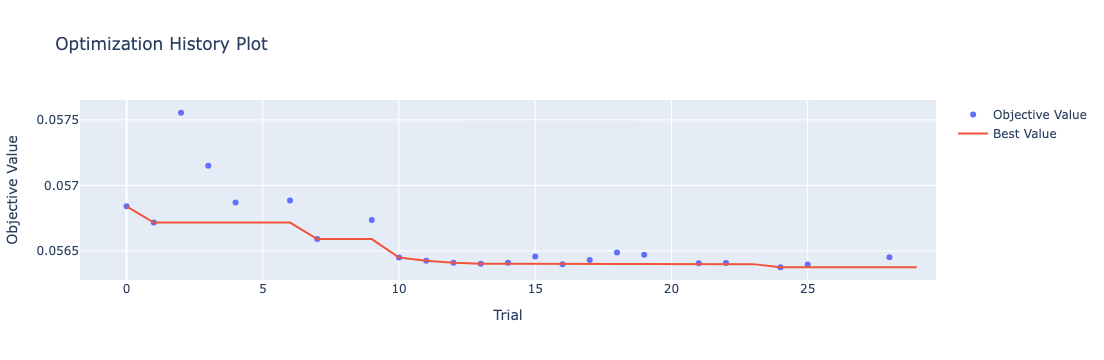

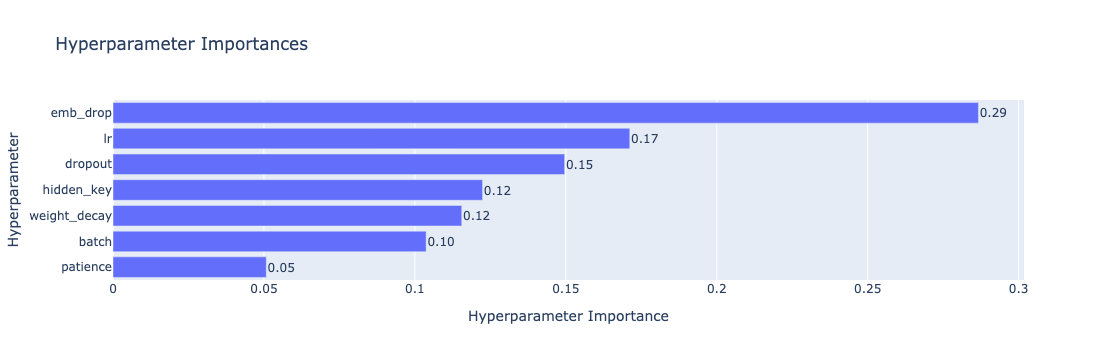

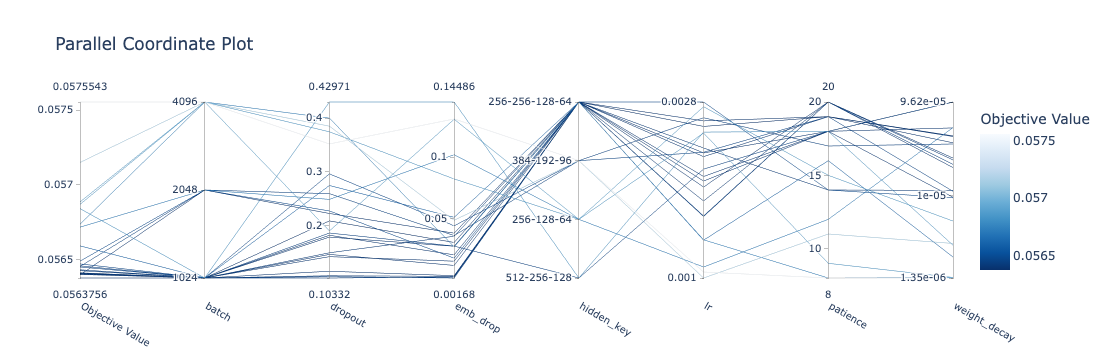

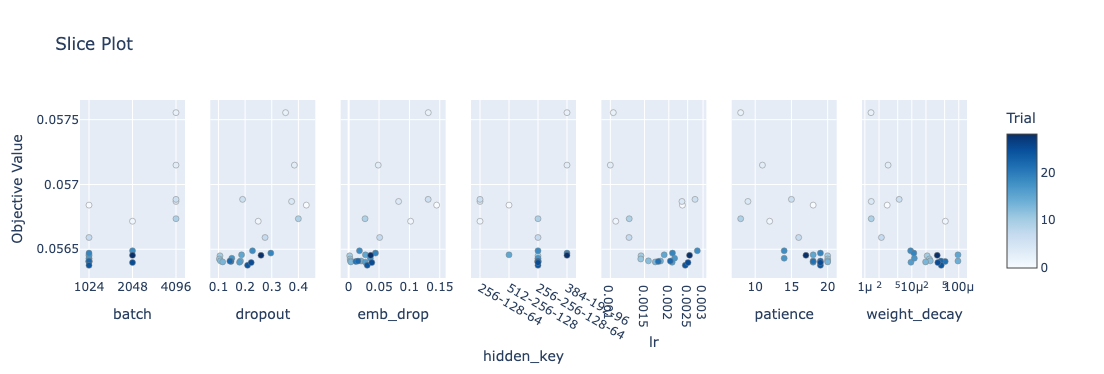

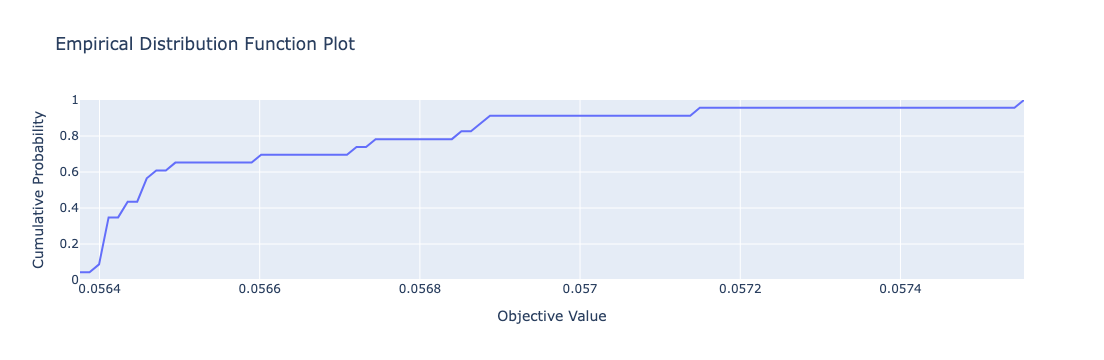

In [20]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_edf,
)

# optimization progress
plot_optimization_history(study).show()

# which parameters mattered most
plot_param_importances(study).show()

# relationships between params
plot_parallel_coordinate(study).show()
plot_slice(study).show()

# empirical distribution of best scores
plot_edf(study).show()

In [24]:
from tqdm.auto import tqdm
best_params = study.best_params.copy()
# decode hidden_key param:
best_params["hidden"] = list(map(int, best_params["hidden_key"].split("-")))

BATCH   = best_params.get("batch", 2048)
LR      = best_params.get("lr", 2e-3)
WD      = best_params.get("weight_decay", 1e-5)
DROPOUT = best_params.get("dropout", 0.2)
EMBDROP = best_params.get("emb_drop", 0.05)
EPOCHS  = 200  # fixed epochs since there's no validation for early stopping

n_cat   = len(meta["cat_cardinalities"])
num_dim = len(meta["num_cols"])

full_ds = TabDataset(X_train, y_train, n_cat)
full_loader = DataLoader(full_ds, batch_size=BATCH, shuffle=True, num_workers=0)

test_ds = TabDataset(X_test, None, n_cat)
test_loader = DataLoader(test_ds, batch_size=BATCH*2, shuffle=False, num_workers=0)

# Model / optimizer
final_model = TabularMLP(
    cat_cardinalities=meta["cat_cardinalities"],
    num_dim=num_dim,
    hidden=best_params["hidden"],
    p=DROPOUT,
    emb_drop=EMBDROP
).to(device)

opt = torch.optim.AdamW(final_model.parameters(), lr=LR, weight_decay=WD)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
criterion = nn.MSELoss()
sigmoid = nn.Sigmoid()

# ---- Train on all data (no early stopping) ----
for ep in tqdm(range(1, EPOCHS+1), desc="Final training (full data)"):
    final_model.train()
    for cat, num, yb in full_loader:
        if cat is not None: cat = cat.to(device)
        if num is not None: num = num.to(device)
        yb = yb.to(device)

        opt.zero_grad()
        yhat = sigmoid(final_model(cat, num))
        loss = criterion(yhat, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        opt.step()
    sched.step()

# ---- Predict test ----
final_model.eval()
test_preds = []
with torch.no_grad():
    for cat, num in tqdm(test_loader, desc="Predict test"):
        if cat is not None: cat = cat.to(device)
        if num is not None: num = num.to(device)
        yhat = sigmoid(final_model(cat, num))
        test_preds.append(yhat.cpu().numpy())

test_preds = np.concatenate(test_preds)
test_preds = np.clip(test_preds, 0, 1)

# ---- Save submission ----
sub = pd.read_csv("sample_submission.csv")
sub["accident_risk"] = test_preds
sub.to_csv("submission_mlp_fullfit.csv", index=False)
print("Saved submission_mlp_fullfit.csv")

Final training (full data):   0%|          | 0/200 [00:00<?, ?it/s]

Predict test:   0%|          | 0/85 [00:00<?, ?it/s]

Saved submission_mlp_fullfit.csv
